In [30]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

df = pd.read_csv('vinclozolin.csv', index_col='exper')

Because the size of data is very small, it's not reasonable to devide it to Train and Test.
All we can do to avoid overfitting is using dropout teqnique

In [351]:
def featurize(data, order=1):
    '''
    Modify independent variable
    We use exponential functions to interpolation. 
    
    param order: degree of exponentioal function
    '''
    
    return np.exp(-(order/10)*data)

def approximate(Y, X, lr):
    # The order of polynom will be increased while `increase_order == True`
    increase_order = True  
    
    # Initial iteration with `order=1`
    model = LinearRegression().fit(Y, X)
    Y_pred = model.predict(featurize(X))
    err = np.mean((Y - Y_pred) ** 2)
    
    order = 2
    while increase_order:
        order += 1
       
        # Fit the model
        model_ = LinearRegression().fit(featurize(X, order), Y)
    
        # Predict
        Y_pred = model_.predict(featurize(X, order))
        
        # Calculate an error on test data
        err_ = np.mean(((Y - Y_pred) / Y_pred) ** 2)
        
        if np.abs(err_ - err) > lr:
        # Continue to increase order, if error change is great
            err = err_
            model = model_
            
        else:
        # Stop increase order, if error change is small
            increase_order = False

    return model, order-1

def fit(Y, X, lr):
    """
    Fit Linear Regression model, finding the best order and coefficient for hiperbolic approximation
    """
    # Reshape data
    Y = np.array(Y).reshape((-1, 1))
    X = np.array(X).reshape((-1, 1))
    
    # Indexes for selecting subsets
    dropouts = [np.random.choice(range(len(Y)), size=len(Y)-1, replace=False) for _ in range(3)]
    
    models = []
    for dropout in dropouts:
        
        # Subsets
        Y_droped = Y[dropout]
        X_droped = X[dropout]
        models.append(approximate(Y_droped, X_droped, lr))
            
    X_ = np.linspace(X.min(), X.max(), 100).reshape((-1,1))
    Y_ = np.mean([model.predict(featurize(X_, order)) for model, order in models], axis=0)
    
    return X_, Y_

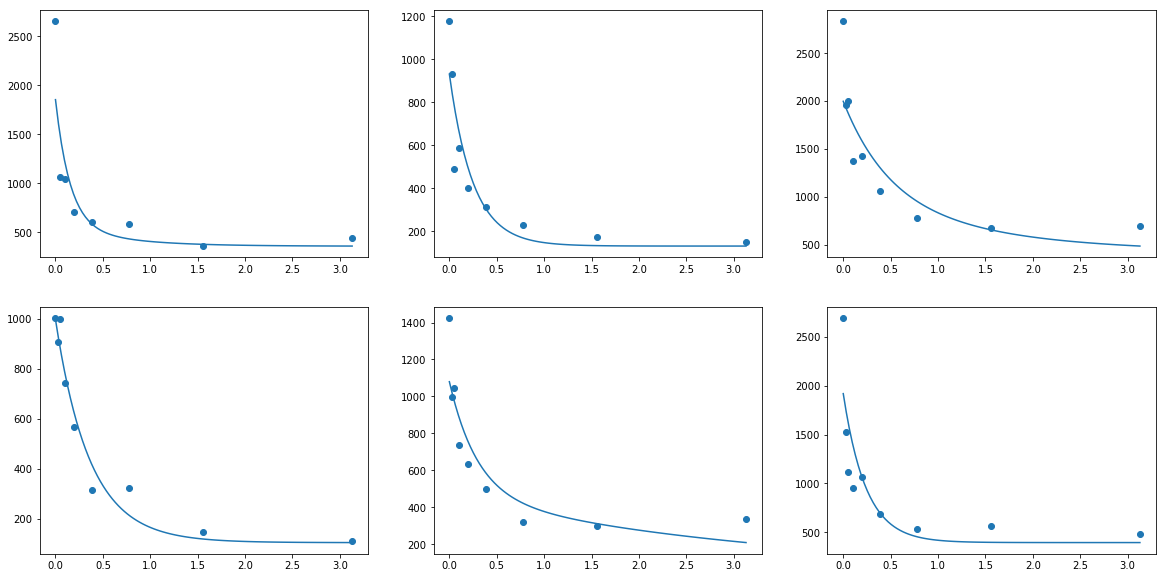

In [355]:
plt.figure(figsize=(20, 10))
for i, exper in enumerate(set(df.index)):
    df_exper = df.loc[exper]
    
    Y = df_exper['effect']
    X = df_exper['conc']
    
    X_, Y_ = fit(Y, X, 0.002)
    
    plt.subplot(2, 3, i+1)
    plt.scatter(X, Y)
    plt.plot(X_, Y_)